**Tutorial 7 - Photometric redshifts.**

In this tutorial we will try to builds models to predict galaxy redshifts from their photometry in 5 bands.

We will get some practice with the scikit-learn package which contains powerful tools for simple machine learning problems. (https://scikit-learn.org/stable/user_guide.html)

1) Import the data from the file reduced_galaxy_data.fits.  This file contains a small subset of data from the Slone Digital Sky Survey.  The columns in the fits table are: id number, the measured spectroscopic redshift, the fluxes in five bands (ugriz), and the magnitudes in the same five bands.  Note that the entry in the flux and magnitude columns is an array of 5 entries.

Put the redshifts into an array called `redshift` and the magnitudes into am two dimensional array `color_block` where `color_block[0]` are the 5 magnitudes for the first entry.

Make a scatter plot of redshift versus u band magnitude.

ColDefs(
    name = 'OBJID'; format = '22A'
    name = 'Z'; format = 'E'
    name = 'MAGNITUDES'; format = '5E'; dim = '(5)'
    name = 'FLUXES'; format = '5E'; dim = '(5)'
)


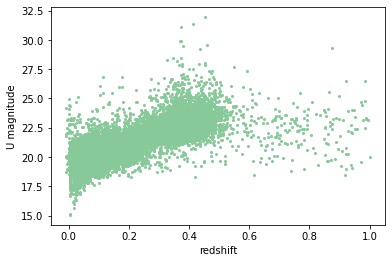

In [162]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pa

filename = "reduced_galaxy_data.fits"
hdul = fits.open(filename)
print(hdul[1].columns)
data = hdul[1].data

redshift = np.array(data['z'])
color_block = np.array(data['MAGNITUDES'])

plt.xlabel('redshift')
plt.ylabel('U magnitude')
plt.scatter(redshift, color_block[:,0],s = 4, color = '#88c999')

plt.show()


2) Subtract the U band magnitude from all the other bands so that we have 4 colors and one apparent magnitude.

In [36]:
for i in np.arange(1,5):
    color_block[:,i] = color_block[:,i] - color_block[:,0]

3) From sklearn import `linear_model`.  Make a `linear_model.LinearRegression(copy_X=True)` object 
and then fit a model that predicts redshifts from the colors. (see https://scikit-learn.org/stable/modules/linear_model.html for more information.)  Print out the coefficients.  Use the model.score() function to give the score for the model which in this case is the R^2 statistic (coefficient of determination).

In [166]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Using only one color, say the g
#gr = color_block[:,1]

#Split the data in training and testing 
gr_train, gr_test, redshift_train, redshift_test = train_test_split (color_block, redshift, test_size = 0.3, random_state=42)

reg = linear_model.LinearRegression(copy_X=True)

reg.fit(gr_train, redshift_train)

redshift_predict = reg.predict(gr_test)

print("Score of Model R^2: {},".format(reg.score(gr_test, redshift_test)))
rmse = np.sqrt(mean_squared_error(redshift_test,redshift_predict))
print("Root Mean Squared Error: {}".format(rmse))

#reg.fit(color_block, redshift)
print("The coefficients are: ")
print(reg.coef_)

#print(reg.score(color_block, redshift))

Score of Model R^2: 0.6809021082800137,
Root Mean Squared Error: 0.0601335772706896
The coefficients are: 
[-0.01683731  0.16540946 -0.01530913 -0.09750297  0.01823478]


4) Use the model to predict the redshifts for all of the galaxies.  Make a scatter plot of the predicted vs observed redshifts. Decreasing the alpha parameter can make this clearer.

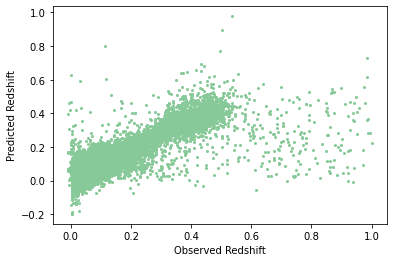

In [175]:

# predict redshifts
predict_all_redshift = reg.predict(color_block)

plt.scatter(redshift, predict_all_redshift, s= 4, color = '#88c999')
plt.ylabel('Predicted Redshift')
plt.xlabel('Observed Redshift')
plt.show()
#plt.scatter(redshift, color_block[:,0],s= 4, color = 'red')


#plt.scatter(redshift, color_block[:,1], color = 'hotpink')
#plt.scatter(predict_all_redshift, color_block[:,1], s= 4, color = 'blue')


#plt.scatter(predict_all_redshift, color_block[:,2], color = 'black')
#plt.scatter(predict_all_redshift, color_block[:,3], color = 'yellow')



# plot prediction vs redshifts


5) Scatter plots can be deceiving.  The density of points can be estimated with a Gaussian kernel.  This should do that.  Put some labels on the plot and overlay a contour plot.  (If you can make a nicer countour plot than this extra point.)

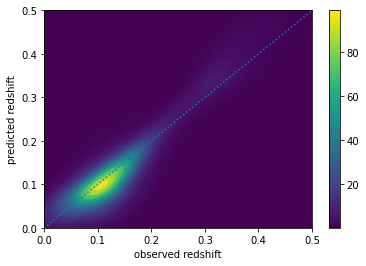

In [176]:
from scipy.stats import kde

nbins = 40
k = kde.gaussian_kde(np.array([predict_all_redshift,redshift]))
#k = kde.gaussian_kde(np.array([color_block[:,2],redshift]))

xi, yi = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi, yi, zi.reshape(xi.shape) )

plt.ylabel('predicted redshift')
plt.xlabel('observed redshift')

plt.show()

6) We are going to need a quick way of assessing how well a model is working.

Make a function that takes the residuals (predictions - true values) and prints six things : 1) their median, 2) mean, 3) the range the contains 90% of the cases with 5% larger and smaller, 4) the same for 80%, 5) the standard deviation and 6) the mean absolute deviation.  

Call this function `report()`.

In [181]:
def report(residuals):
    print("The median of residuals is ", np.median(residuals))
    print("The mean of residuals is ", np.mean(residuals))
    print("The standard deviation is ", np.std(residuals))
    print("The mean absolute deviation is ", np.sum (np.absolute(np.mean(residuals) - residuals)) / len(residuals))
    print("The middle 90% of cases start from ", np.percentile(residuals, 5), " and end at ", np.percentile(residuals, 95))
    print("The middle 80% of cases start from ", np.percentile(residuals, 10), " and end at ", np.percentile(residuals, 90))


7) We need a quick way of calculating the residuals, but we cannot calculate the residuals on the same data as we fit the model.  Let's make a function the splits the data in two, fits on one subset and calculates the residuals on the remaining subset.

The function should take the independent variables `X`, the dependent variable `Y`, the model `model` and the fraction of the data set that will be used for fitting the the model.  The `model` has the functions `fit()` and `predict()` as for the sklearn models.  The function should split the data set into two random subsets: fit and test.  It should then fit the model and then return the residuals for the test set and the true Y values of the test set.

In [182]:
def test_residuals(X,Y,model,fit_fraction):
   
    N = np.size(Y)
    # make and index
    index = np.arange(0, N, 1)
    # shuffle the index
    np.random.shuffle(index)
    
    #split the index into two parts 
    
    split = int(fit_fraction*(N))
    index_fit = index[0: split]
    index_test = index[split:]

    # define X_fit,Y_fit
    Y_fit = np.empty(split) 
    X_fit = np.empty((split, X.shape[1]))
    
    for i in range(split):
        Y_fit[i] = Y[index_fit[i]]
        
    for g in range(split):
        X_fit[g] = X[index_fit[g]]
            
   
    # define X_test, Y_test
    
    Y_test = np.empty(N - split)
    X_test = np.empty((N - split, X.shape[1]))
    
    for k in range(N - split):
        Y_test[k] = Y[index_test[k]]
        X_test[k] = X[index_test[k]]
 
    ## fit model
                    
 
    model.fit(X_fit, Y_fit)
    
    #fit(X_fit, Y_fit)
   
    ## predict redshifts
    y_predict = model.predict(X_test)
    
  
    return (y_predict - Y_test), Y_test, y_predict

8) Use your function `test_residuals()` to get a set of residuals with `linear_mod` and our data.  Use 80% of the data for fitting and 20% for testing. Run `report()` on the resulting residuals to see how well this model predicts the redshifts.

In [183]:
a,c,f = test_residuals(color_block, redshift, linear_model.LinearRegression(copy_X=True), 0.8)
print("Report:",report(a))

The median of residuals is  0.0026992040019059305
The mean of residuals is  -2.727506989973035e-05
The standard deviation is  0.05799937803316803
The mean absolute deviation is  0.03349023384946271
The middle 90% of cases start from  -0.06757418816471131  and end at  0.06960337110461341
The middle 80% of cases start from  -0.04598403163740576  and end at  0.05050725845471157
Report: None


9) Make a nice histogram of the residuals.

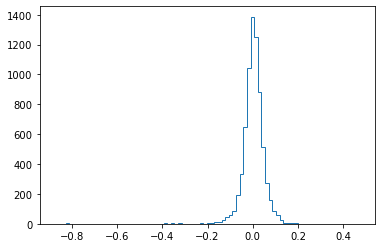

In [185]:
b = plt.hist(a,  bins=int(np.sqrt(len(a))), histtype='step', linewidth=1)
plt.show()

10) What is important is that the fractional error in the redshift is small, i.e. `residuals / y`.  Find the fractional residuals, run them through `report` and make a histogram of them.

The median of residuals is  0.022287082597283042
The mean of residuals is  0.5746434431161597
The standard deviation is  30.88364368271374
The mean absolute deviation is  1.199617808259962
The middle 90% of cases start from  -0.5663203452181593  and end at  1.2300717084745227
The middle 80% of cases start from  -0.34892473562975557  and end at  0.6953259264694314


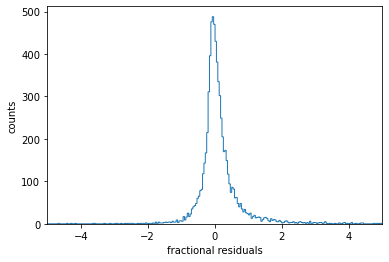

In [186]:
frac_error = a/c
report(frac_error)

d = plt.hist(frac_error, bins='auto', histtype='step', linewidth=1)
plt.xlim(-5,5)
plt.xlabel('fractional residuals')
plt.ylabel('counts')
plt.show()

11) Would you consider this a successful model in terms of the fractional residuals?

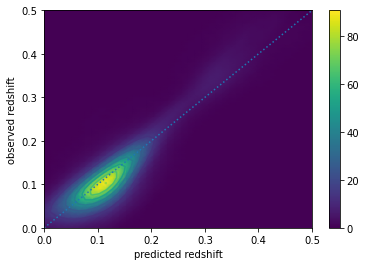

No the standard deviation is high and the contour plot shows that the data is scattered, whereas we expect it to be linear


In [190]:
from scipy.stats import kde

nbins = 40
#k = kde.gaussian_kde(np.array([predictions,observations]))
k = kde.gaussian_kde(np.array([f,c]))

xi, yi = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi, yi, zi.reshape(xi.shape) )

plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')

plt.show()
print("No the standard deviation is high and the contour plot shows that the data is scattered, whereas we expect it to be linear")


12) So far, the model has been linear in the parameters AND the colors/magnitude.  It might improve the model if we include terms in the model that are second order in the colors while keeping it linear in the parameters.

sklearn provides a convenient function that will transform our matrix of colors into a larger matrix that includes higher order terms.  In particular, `PolynomialFeatures(2).fit_transform(color_block)` will include all the colors squared and all the products of the colors.

Use this function to transform our `color_block` into another one with second order terms.

How many more parameters will be in a linear model fit with this new data matrix?

In [144]:
from sklearn.preprocessing import PolynomialFeatures

color_block2 = PolynomialFeatures(2).fit_transform(color_block)

13) Create and fit a new linear model using this new data matrix.
    
What is the score for this model?

In [194]:
gr2_train, gr2_test, redshift2_train, redshift2_test = train_test_split (color_block2, redshift, test_size = 0.3, random_state=42)

reg2 = linear_model.LinearRegression(copy_X=True)

reg2.fit(gr2_train, redshift2_train)

redshift_predict2= reg2.predict(gr2_test)

print("Score of model R^2: {}".format(reg2.score(gr2_test, redshift2_test)))
rmse2 = np.sqrt(mean_squared_error(redshift2_test,redshift_predict2))
print("Root Mean Squared Error: {}".format(rmse2))

#reg.fit(color_block, redshift)
print("The coefficients are")
print(reg2.coef_)



Score of model R^2: 0.7293638851886882
Root Mean Squared Error: 0.05537936197454392
The coefficients are
[ 0.         -0.2918087   0.75231967 -1.11669178 -0.84451233  1.11762052
  0.00870198 -0.02590105  0.04684537  0.03620315 -0.04692379 -0.04947955
  0.12860552 -0.08855922  0.01477815 -0.01404892  0.01518619 -0.06461325
  0.02388855  0.04447915 -0.00797799]


14) Use your functions `test_residuals()` and `report()` with this new model as before.  Make a histogram of the residuals as before.

The median of residuals is  0.0011550733421130666
The mean of residuals is  0.0009354939420466321
The standard deviation is  0.05390064958950557
The mean absolute deviation is  0.02851075234165479
The middle 90% of cases start from  -0.05614857359499532  and end at  0.060141185302087515
The middle 80% of cases start from  -0.03600504567133056  and end at  0.04340236912690443
Report: None


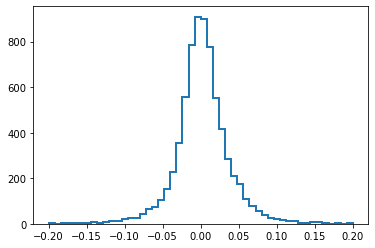

In [207]:
a2,c2,d2 = test_residuals(color_block2, redshift, linear_model.LinearRegression(copy_X=True), 0.8)
print("Report:",report(a2))
b2 = plt.hist(a2, bins=50, histtype='step', linewidth=2, range=(-0.2,0.2))
plt.show()

15) As before, do the same for the fractional residuals.

The median of residuals is  0.008967702153187332
The mean of residuals is  -2.387146513785279
The standard deviation is  236.57190271300632
The mean absolute deviation is  5.984846103175459
The middle 90% of cases start from  -0.3664867229486726  and end at  1.1898159019411996
The middle 80% of cases start from  -0.2524024059399406  and end at  0.6690127144516864


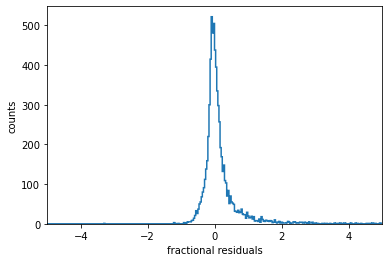

None


In [208]:
frac_residualpar=report(a2/c2)
plt.hist(a2/c2, bins='auto', histtype='step', linewidth=1.5)
#plt.vlines(min(frac_resi_par[2]), 0, 1500, linestyles='--')
#plt.vlines(max(frac_resi_par[2]), 0, 1500, linestyles='--')
plt.xlim(-5,5)
plt.xlabel('fractional residuals')
plt.ylabel('counts')
plt.show()
print(frac_residualpar)

16) Make a new contour plot for predictions based on `color_block2`.

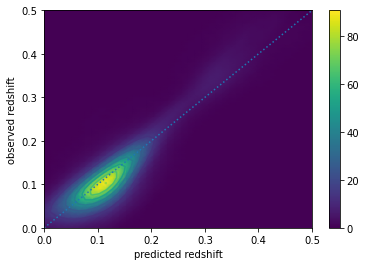

In [197]:
nbins = 40
#k = kde.gaussian_kde(np.array([predictions,observations]))
k2 = kde.gaussian_kde(np.array([d2,c2]))

xi2, yi2 = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi2 = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud')
plt.plot([0,0.5],[0,0.5],linestyle=':')
plt.colorbar()

plt.contour(xi2, yi2, zi2.reshape(xi2.shape) )

plt.xlabel('predicted redshift')
plt.ylabel('observed redshift')

plt.show()
#print("I don't think so")

17) Uses `sklearn.model_selection.cross_val_score` to find an estimate of the mean absolute error using k-fold validation. (scoring="neg_mean_absolute_error", cv=5)

In [206]:
from sklearn.model_selection import cross_val_score
score_1=cross_val_score(reg2, color_block, redshift, scoring="neg_mean_absolute_error", cv=5)
score_2=cross_val_score(reg2, color_block2, redshift, scoring="neg_mean_absolute_error", cv=5)
print("Score of the first model:", np.mean(score_1))
print("Score of the second model:",np.mean(score_2))

Score of the first model: -0.03377666625556824
Score of the second model: -0.028637003103396296


18) Is this model an improvement on the first one?

In [209]:
print("The second seems to be better due to the mean absolute error and a higher score ")

The second seems to be better due to the mean absolute error and a higher score 
